In [25]:
import geopandas as gpd
from pathlib import Path
import json

In [5]:
file_name = '/home/cajanond/Documents/omdena/GPSDD-Food-Security-Senegal/src/results/task_1_climate-risk/data/geodf_unit.shp'
gdf = gpd.read_file(filename=file_name)

In [7]:
gdf.head(1)

,adm2_name_,NAME,severity_2,phase1_201,phase2_201,phase3_201,phase4_201,phase5_201,severity_1,phase1_2_1,...,phase3_2_5,phase4_2_5,phase5_2_5,severity_7,phase1_2_6,phase2_2_6,phase3_2_6,phase4_2_6,phase5_2_6,geometry
0,25,Foundiougne,1.883139,0.5,0.471999,0.025,0.003001,0.0,1.562505,0.75,...,0.0,0.0,0.0,1.060001,0.96,0.04,0.0,0.0,0.0,"MULTIPOLYGON (((-16.63903 13.68070, -16.63903 ..."


In [8]:
gdf.columns


Index(['adm2_name_', 'NAME', 'severity_2', 'phase1_201', 'phase2_201',
       'phase3_201', 'phase4_201', 'phase5_201', 'severity_1', 'phase1_2_1',
       'phase2_2_1', 'phase3_2_1', 'phase4_2_1', 'phase5_2_1', 'severity_3',
       'phase1_2_2', 'phase2_2_2', 'phase3_2_2', 'phase4_2_2', 'phase5_2_2',
       'severity_4', 'phase1_2_3', 'phase2_2_3', 'phase3_2_3', 'phase4_2_3',
       'phase5_2_3', 'severity_5', 'phase1_2_4', 'phase2_2_4', 'phase3_2_4',
       'phase4_2_4', 'phase5_2_4', 'severity_6', 'phase1_2_5', 'phase2_2_5',
       'phase3_2_5', 'phase4_2_5', 'phase5_2_5', 'severity_7', 'phase1_2_6',
       'phase2_2_6', 'phase3_2_6', 'phase4_2_6', 'phase5_2_6', 'geometry'],
      dtype='object')

In [20]:
ROOT_FOLDER = Path.cwd().parent. parent
DATA_FOLDER = ROOT_FOLDER.joinpath("data", "external", 'asap', 'region')
GEO_FOLDER = Path(ROOT_FOLDER).joinpath('data/external/RegionsShapefiles')
MAX_SEVERITY = 5

files = list(Path(GEO_FOLDER).glob('*'))

In [26]:
from src.data.task_1_food_security.dataset import Dataset

ds = Dataset(root_folder=ROOT_FOLDER)
ds.prepare_dataset_array()
units = ds.code2unit()
unit_names = units['adm2_name'].values
unit_dict = {'type': 'FeatureCollection', 'features': []}

for file in files:
    loaded_name = str(file).split('/')[-1].split('.')[0]
    unit_name = ds.match_unit(loaded_name, unit_names)
    unit_code = units[units['adm2_name'] == unit_name]['code'].values[0]
    with open(file) as f:
        loaded_feature = json.load(f)
    if len(loaded_feature['features']) > 1:
        print("More than one feature. Stopping...")
        break
    loaded_feature = loaded_feature['features'][0]
    loaded_feature['properties']['NAME'] = unit_name
    loaded_feature['properties']['COUNTY'] = unit_code
    loaded_feature['geometry']['id'] = unit_code
    unit_dict['features'].append(loaded_feature)

In [28]:
df_unit = gpd.GeoDataFrame.from_features(unit_dict)
df_unit.columns = ['geometry', 'NAME', 'adm2_name_code']
df_unit.set_index('adm2_name_code', inplace=True)
for y in range(2013, 2020):
    df_y = ds.df_y.copy()
    df_y.reset_index(inplace=True)
    df_y =  df_y[df_y['season'] == y]
    df_y = df_y[['adm2_name_code', 'severity'] + [f"phase{i}" for i in range(1, 6)]]
    df_y.columns = ['adm2_name_code', f'severity_{y}'] + [f"phase{i}_{y}" for i in range(1, 6)]
    df_y['adm2_name_code'] = df_y['adm2_name_code'].astype(int)
    df_y.set_index('adm2_name_code', inplace=True)
    df_unit = df_unit.join(df_y)

In [29]:
df_unit.head()

,geometry,NAME,severity_2013,phase1_2013,phase2_2013,phase3_2013,phase4_2013,phase5_2013,severity_2014,phase1_2014,...,phase2_2018,phase3_2018,phase4_2018,phase5_2018,severity_2019,phase1_2019,phase2_2019,phase3_2019,phase4_2019,phase5_2019
adm2_name_code,,,,,,,,,,,,,,,,,,,,,
25,"MULTIPOLYGON (((-16.63903 13.68070, -16.63903 ...",Foundiougne,1.883139,0.500000,0.471999,0.025000,0.003001,0.0,1.562505,0.750000,...,0.110000,0.000000,0.0,0.0,1.060001,0.960000,0.040000,0.000000,0.0,0.0
19,"POLYGON ((-14.99165 13.80161, -14.99178 13.801...",Koungheul,1.330016,0.829998,0.150001,0.020002,0.000000,0.0,1.554995,0.830003,...,0.139998,0.010000,0.0,0.0,1.517497,0.780000,0.170000,0.049999,0.0,0.0
39,"POLYGON ((-15.47068 12.98113, -15.47475 12.955...",Bounkiling,1.990030,0.589997,0.310001,0.100002,0.000000,0.0,1.442474,0.830004,...,0.140001,0.010000,0.0,0.0,1.165003,0.889998,0.110002,0.000000,0.0,0.0
26,"POLYGON ((-16.16108 14.55332, -16.16127 14.553...",Diourbel,1.631865,0.650001,0.324001,0.024999,0.001000,0.0,1.637503,0.700001,...,0.170001,0.019999,0.0,0.0,1.637499,0.700000,0.250001,0.050000,0.0,0.0
8,"POLYGON ((-16.53875 15.79223, -16.54006 15.792...",Saint Louis,1.194998,0.870001,0.129999,0.000000,0.000000,0.0,1.255003,0.879998,...,0.099999,0.000000,0.0,0.0,1.105001,0.929999,0.070001,0.000000,0.0,0.0


In [36]:
# file_name = ROOT_FOLDER.joinpath("src/results/task_1_climate-risk/data/geodf_unit.json")
#
# df_unit.to_file(filename=file_name, driver='GeoJSON')

In [49]:
df_unit2 = gpd.read_file(filename=file_name)

In [50]:
df_unit2.columns

Index(['adm2_name_code', 'NAME', 'severity_2013', 'phase1_2013', 'phase2_2013',
       'phase3_2013', 'phase4_2013', 'phase5_2013', 'severity_2014',
       'phase1_2014', 'phase2_2014', 'phase3_2014', 'phase4_2014',
       'phase5_2014', 'severity_2015', 'phase1_2015', 'phase2_2015',
       'phase3_2015', 'phase4_2015', 'phase5_2015', 'severity_2016',
       'phase1_2016', 'phase2_2016', 'phase3_2016', 'phase4_2016',
       'phase5_2016', 'severity_2017', 'phase1_2017', 'phase2_2017',
       'phase3_2017', 'phase4_2017', 'phase5_2017', 'severity_2018',
       'phase1_2018', 'phase2_2018', 'phase3_2018', 'phase4_2018',
       'phase5_2018', 'severity_2019', 'phase1_2019', 'phase2_2019',
       'phase3_2019', 'phase4_2019', 'phase5_2019', 'severity_LSTM_2019',
       'season', 'adm2_name', 'severity', 'phase1', 'phase2', 'phase3',
       'phase4', 'phase5', 'adm2_name_old', 'sample', 'severity_linreg',
       'severity_xgboost', 'geometry'],
      dtype='object')

In [41]:
df_unit2['severity_LSTM_2019']


0     1.636547
1     2.351280
2     1.347777
3     1.267043
4     1.471249
5     1.873387
6     1.782712
7     2.015889
8     1.293851
9     1.717648
10    2.490702
11    1.918019
12    1.493381
13    1.458181
14    1.779196
15    1.595197
16    1.400448
17    1.530285
18    1.680133
19    1.504344
20    1.337862
21    1.626371
22    1.500386
23    1.592615
24    1.647581
25    1.347896
26    1.256999
27    1.491541
28    1.478483
29    1.605892
30    1.345253
31    1.506116
32    1.562294
33    1.761172
34    1.690558
35    2.422229
36    2.032196
37    1.502120
38    1.398590
39    1.524747
40    1.601074
41    1.759250
42    2.310259
43    1.562099
44    1.435611
Name: severity_LSTM_2019, dtype: float64

In [42]:
df_unit2['severity_2013']

0     1.883139
1     1.330016
2     1.990030
3     1.631865
4     1.194998
5     1.329983
6     1.314992
7     1.255007
8     1.502484
9     1.150000
10    3.343884
11    1.146253
12    2.833738
13    2.743736
14    1.652498
15    1.577490
16    1.637507
17    2.799965
18         NaN
19    3.100007
20    3.025021
21    1.472412
22    1.397522
23    1.378752
24    1.922484
25    1.525017
26    2.041774
27    1.487493
28    1.262500
29    1.179999
30    1.358197
31    2.158744
32    1.719987
33    1.434987
34    1.397498
35         NaN
36         NaN
37    1.465002
38    1.534363
39    2.068748
40    2.537498
41    2.019995
42    1.787467
43    1.329999
44    1.689996
Name: severity_2013, dtype: float64

<AxesSubplot:>

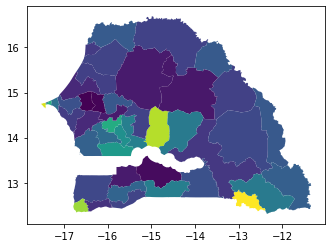

In [43]:
df_unit2.plot('severity_LSTM_2019')


<AxesSubplot:>

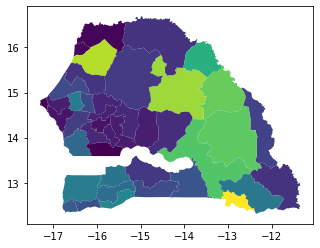

In [44]:
df_unit2.plot('severity_2013')